In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-97f90efc-be50-4133-43ff-77d91543be5b)


In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.utils import plot_model
import os

In [ ]:
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')

In [ ]:
batch_size = 32
num_classes = 20
FreezedEpochs = 250
UnfreezedEpochs = 100

In [ ]:
def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn', x[0], x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	          # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,7*7)							  	  # Divide by feature map size [size * size]

  y_ssqrt = tf.multiply(                            # Take signed square root of phi_I
      tf.sign(phi_I),
      tf.sqrt(tf.abs(phi_I)+1e-12)
      )
  
  z_l2 = tf.nn.l2_normalize(y_ssqrt)							  # Apply l2 normalization
  
  return z_l2

datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True
  )

def multiple_data_generator(generator, X,Y,bs):
    genX = generator.flow(X, Y, batch_size=bs)
    while True:
      [Xi,Yi] = genX.next()
      yield [Xi,Xi],Yi

In [ ]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train=y_train-1
y_test=y_test-1

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

vgg1 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=x_train.shape[1:]
)
vgg2 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=x_train.shape[1:]
)

for layer in vgg1.layers:
  layer._name = layer._name + str('_1')
  layer.trainable = False;
for layer in vgg2.layers:
  layer._name = layer._name + str('_2')
  layer.trainable = False;

vgg1.summary()
vgg2.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_1 (InputLayer)       [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1_1 (Conv2D)      (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2_1 (Conv2D)      (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool_1 (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1_1 (Conv2D)      (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2_1 (Conv2D)      (None, 125, 125, 128)     147584    
______________________________________________________________

In [ ]:
vggOut1 = vgg1.get_layer('block5_pool_1').output

vggOut2 = vgg2.get_layer('block5_pool_2').output

x = Lambda(outer_product, name='outer_product')([vggOut1,vggOut2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=[vgg1.input, vgg2.input], outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 250, 250, 64) 1792        input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 250, 250, 64) 1792        input_2_2[0][0]                  
______________________________________________________________________________________________

In [ ]:

history_frozen=model.fit(x=multiple_data_generator(datagen, x_train, y_train, batch_size),
                  epochs=FreezedEpochs,
                  steps_per_epoch = len(x_train) / batch_size,
                  validation_data=([x_test, x_test], y_test),
                  verbose=1
)


Epoch 1/250
24/24 [==============================] - 96s 2s/step - loss: 2.9947 - accuracy: 0.0716 - val_loss: 2.9901 - val_accuracy: 0.1110
Epoch 2/250
24/24 [==============================] - 19s 791ms/step - loss: 2.9873 - accuracy: 0.1224 - val_loss: 2.9844 - val_accuracy: 0.1620
Epoch 3/250
24/24 [==============================] - 19s 787ms/step - loss: 2.9801 - accuracy: 0.1619 - val_loss: 2.9790 - val_accuracy: 0.1645
Epoch 4/250
24/24 [==============================] - 19s 791ms/step - loss: 2.9730 - accuracy: 0.1312 - val_loss: 2.9736 - val_accuracy: 0.1531
Epoch 5/250
24/24 [==============================] - 19s 790ms/step - loss: 2.9648 - accuracy: 0.1592 - val_loss: 2.9681 - val_accuracy: 0.1760
Epoch 6/250
24/24 [==============================] - 19s 798ms/step - loss: 2.9610 - accuracy: 0.1440 - val_loss: 2.9629 - val_accuracy: 0.1862
Epoch 7/250
24/24 [==============================] - 19s 805ms/step - loss: 2.9527 - accuracy: 0.1780 - val_loss: 2.9578 - val_accuracy: 0.

In [ ]:
for layer in vgg1.layers:
  layer.trainable = True

for layer in vgg2.layers:
  layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 250, 250, 64) 1792        input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 250, 250, 64) 1792        input_2_2[0][0]                  
______________________________________________________________________________________________

In [ ]:

history2=model.fit(x=multiple_data_generator(datagen, x_train, y_train, batch_size),
                  epochs=UnfreezedEpochs,
                  steps_per_epoch = len(x_train) / batch_size,                 
                  validation_data=([x_test, x_test], y_test),
                  verbose=1
)

Epoch 1/100
24/24 [==============================] - 48s 2s/step - loss: 1.8675 - accuracy: 0.7004 - val_loss: 1.9255 - val_accuracy: 0.5242
Epoch 2/100
24/24 [==============================] - 34s 1s/step - loss: 1.6582 - accuracy: 0.7496 - val_loss: 1.8327 - val_accuracy: 0.5497
Epoch 3/100
24/24 [==============================] - 34s 1s/step - loss: 1.5702 - accuracy: 0.7780 - val_loss: 1.7596 - val_accuracy: 0.5727
Epoch 4/100
24/24 [==============================] - 34s 1s/step - loss: 1.5196 - accuracy: 0.7524 - val_loss: 1.7079 - val_accuracy: 0.5804
Epoch 5/100
24/24 [==============================] - 34s 1s/step - loss: 1.4379 - accuracy: 0.7757 - val_loss: 1.6600 - val_accuracy: 0.6097
Epoch 6/100
24/24 [==============================] - 34s 1s/step - loss: 1.3748 - accuracy: 0.8246 - val_loss: 1.6269 - val_accuracy: 0.6046
Epoch 7/100
24/24 [==============================] - 34s 1s/step - loss: 1.3296 - accuracy: 0.7793 - val_loss: 1.5959 - val_accuracy: 0.6199
Epoch 8/100
2

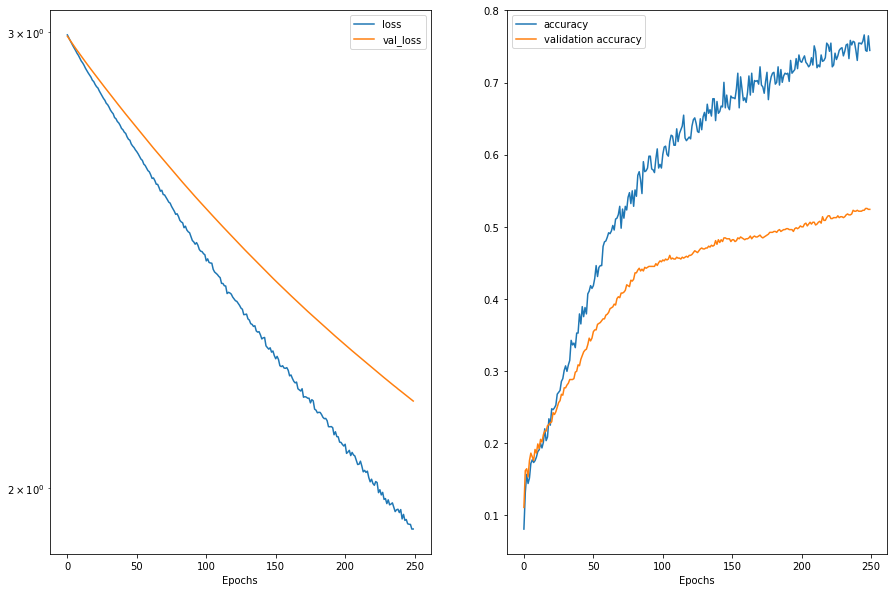

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.set_yscale('log')
ax1.plot(history_frozen.history['loss'], label="loss")
ax1.plot(history_frozen.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history_frozen.history['accuracy'], label="accuracy")
ax2.plot(history_frozen.history['val_accuracy'], label="validation accuracy")
ax2.legend()

plt.setp(ax1, xlabel='Epochs')
plt.setp(ax2, xlabel='Epochs')
plt.show();

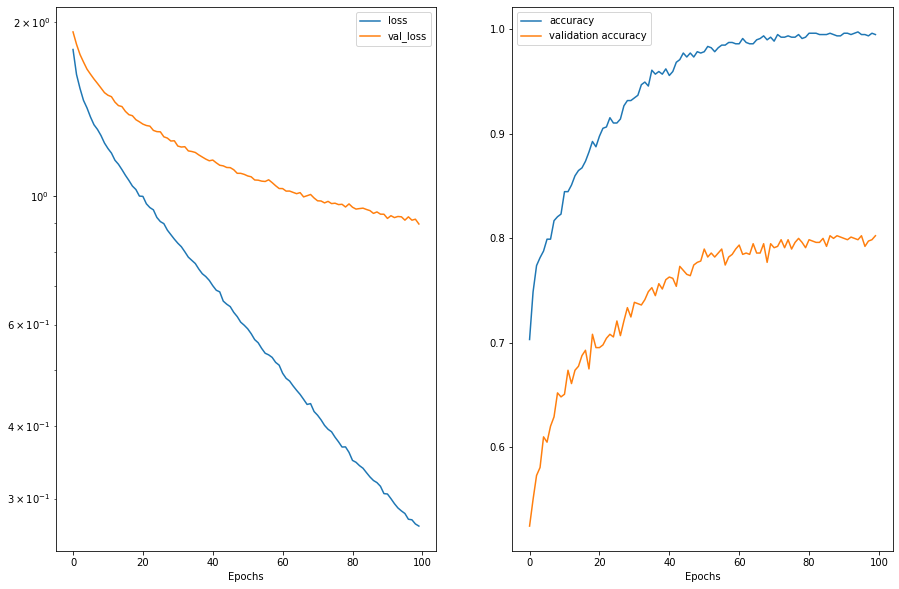

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.set_yscale('log')
ax1.plot(history2.history['loss'], label="loss")
ax1.plot(history2.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history2.history['accuracy'], label="accuracy")
ax2.plot(history2.history['val_accuracy'], label="validation accuracy")
ax2.legend()

plt.setp(ax1, xlabel='Epochs')
plt.setp(ax2, xlabel='Epochs')
plt.show();